# Прогнозирование цен потребительского ритейла по тестовой выборке на основе глубоких нейронных сетей
__Выполнил:__ *Домченко Максим*

__Студент группы:__ *РИМ-130962*

In [2]:
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
ROOT = Path('/content/drive/MyDrive')

PROJECT_DIR = ROOT / 'price_forecasting'
DATA = PROJECT_DIR / 'data'
MODELS = PROJECT_DIR / 'models'

print('Проектная папка подключена:', PROJECT_DIR)

Mounted at /content/drive
Проектная папка подключена: /content/drive/MyDrive/price_forecasting


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

sns.set_style("whitegrid")

In [7]:
import pickle
import pandas as pd

# Список файлов с метриками
metric_files = {
    "ARIMA": MODELS / "arima_top10_FOODS_1_096_metrics.pkl",
    "Prophet": MODELS / "prophet_top_item_metrics.pkl",
    "XGBoost": MODELS / "xgboost_model_extended_metrics.pkl",
    "TFT": MODELS / "tft_model_limited_dataset_metrics.pkl",
}

# Загрузка и распаковка метрик
metrics_dict = {}
for model_name, file_path in metric_files.items():
    with open(file_path, 'rb') as f:
        metrics = pickle.load(f)

        # Проверяем наличие разделения на выборки (по '_test')
        if any('_test' in key for key in metrics.keys()):
            test_metrics = {k.replace('_test', ''): v for k, v in metrics.items() if '_test' in k}
        else:
            test_metrics = metrics

        # Дополнительная распаковка словаря, если значения в виде вложенного словаря (например, TFT)
        for key, value in test_metrics.items():
            if isinstance(value, dict):  # если вложенный словарь, распаковываем первый уровень
                for inner_key, inner_value in value.items():
                    metrics_dict.setdefault(model_name, {})[inner_key] = inner_value
            else:
                metrics_dict.setdefault(model_name, {})[key] = value

# Создание DataFrame с метриками тестовой выборки
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index').reset_index().rename(columns={'index': 'Model'})

display(metrics_df)

,Model,MAE,MSE,RMSE,MAPE,R2
0,ARIMA,0.006860,0.000073,0.008532,0.343444,-1.829549
1,Prophet,0.102777,0.011013,0.104945,0.048704,-1109.382372
2,XGBoost,1.257825,5.052282,2.247728,0.597437,0.215391
3,TFT,0.041476,0.003630,0.060250,0.030309,0.988028


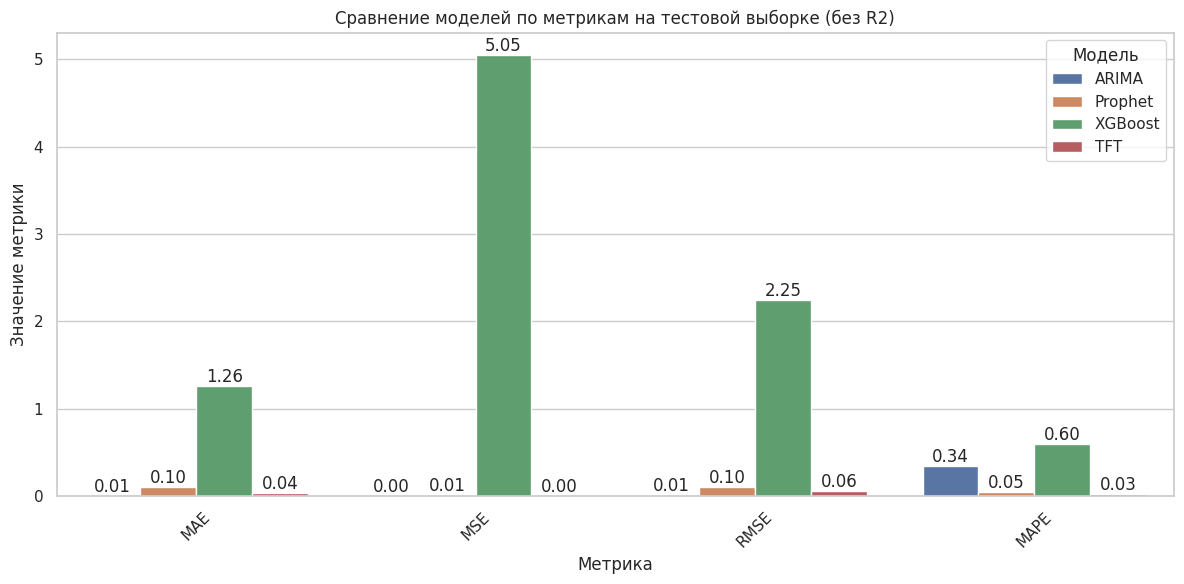

<ipython-input-9-bf2035d505e2>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_r2, x='Model', y='R2', palette='coolwarm')


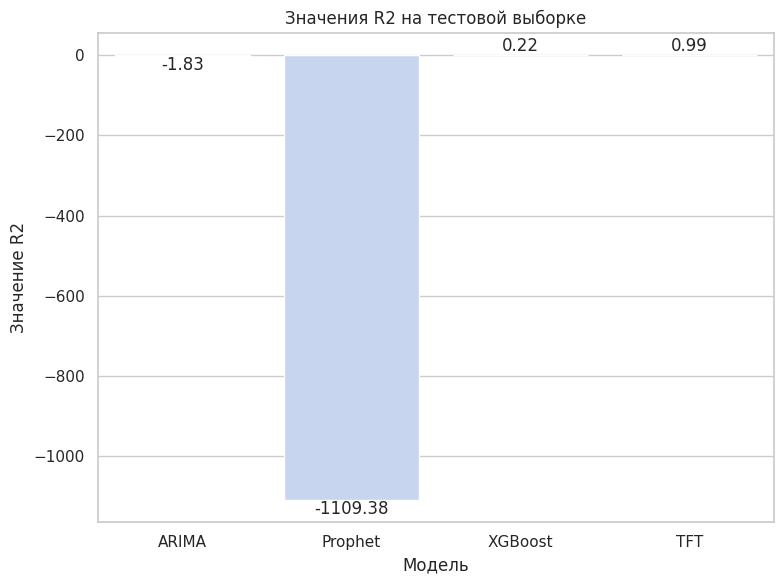

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Настройка стиля графиков
sns.set(style="whitegrid")

# Выделяем метрику R2 отдельно из-за значительных отклонений
metrics_no_r2 = metrics_df.drop(columns=['R2'])
metrics_r2 = metrics_df[['Model', 'R2']]

# Подготовка данных для визуализации
metrics_melted = metrics_no_r2.melt(id_vars='Model', var_name='Metric', value_name='Value')

# График метрик без R2
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_melted, x='Metric', y='Value', hue='Model')

plt.title('Сравнение моделей по метрикам на тестовой выборке (без R2)')
plt.ylabel('Значение метрики')
plt.xlabel('Метрика')
plt.legend(title='Модель')
plt.xticks(rotation=45)

# Добавляем аннотации с точностью до 2 знаков
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

# Отдельный график для R2
plt.figure(figsize=(8, 6))
sns.barplot(data=metrics_r2, x='Model', y='R2', palette='coolwarm')

plt.title('Значения R2 на тестовой выборке')
plt.ylabel('Значение R2')
plt.xlabel('Модель')

# Добавляем аннотации с точностью до 2 знаков
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

<ipython-input-10-584120cdc2ce>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')


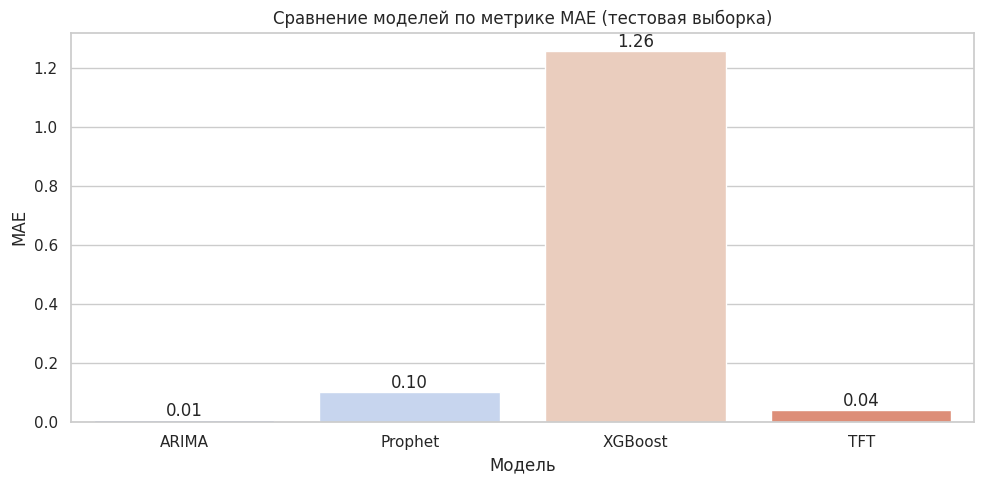

<ipython-input-10-584120cdc2ce>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')


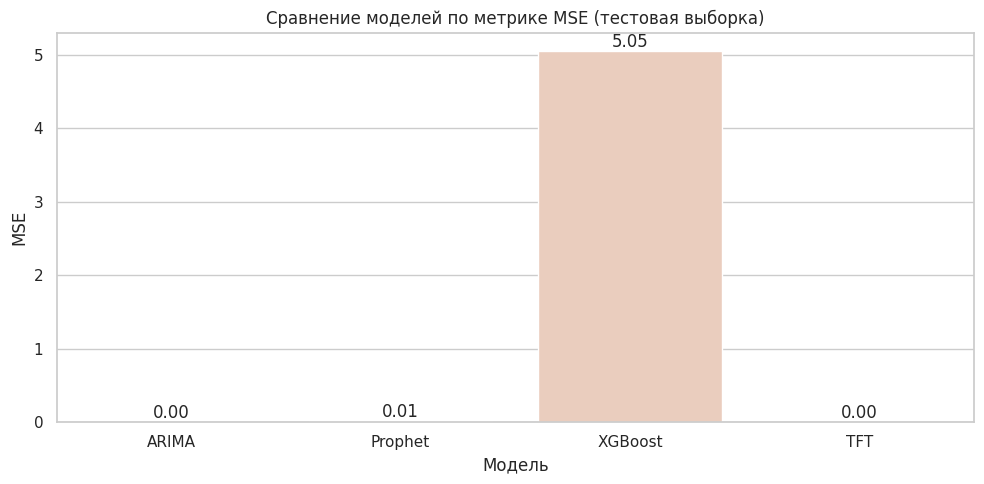

<ipython-input-10-584120cdc2ce>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')


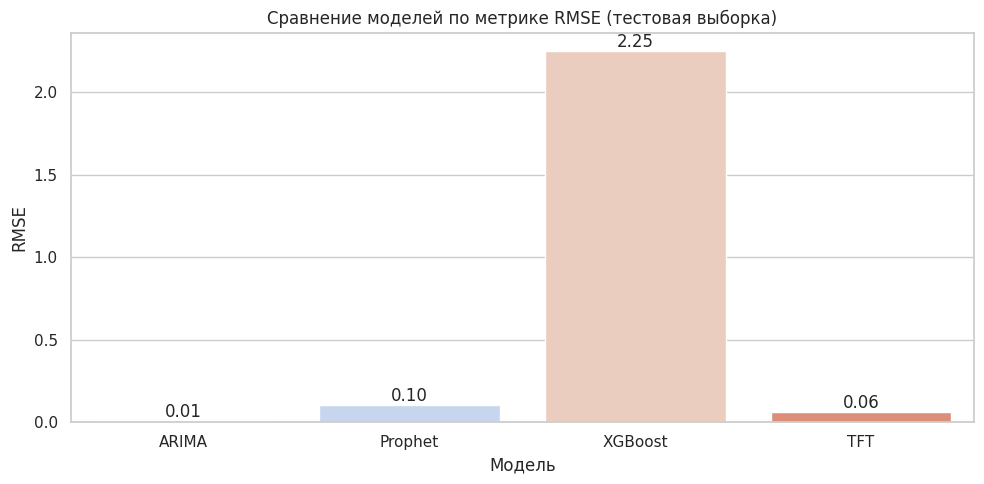

<ipython-input-10-584120cdc2ce>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')


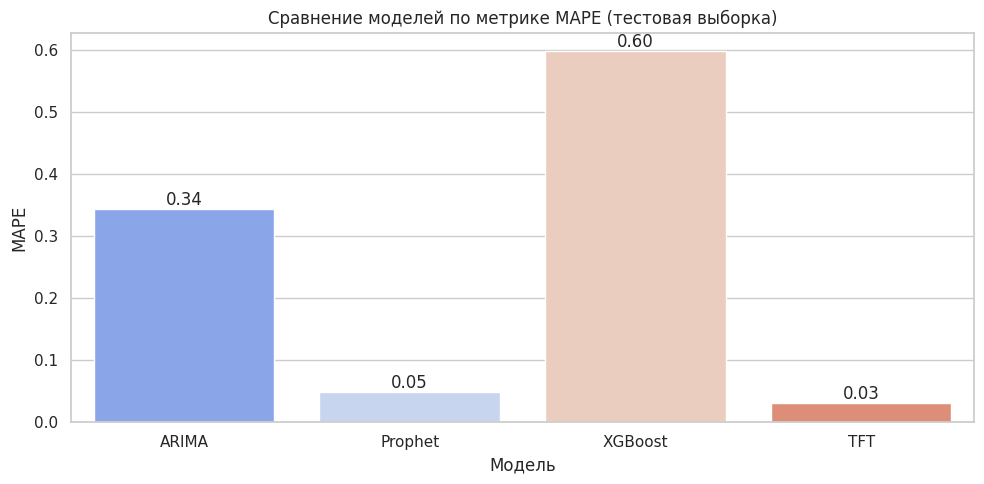

<ipython-input-10-584120cdc2ce>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')


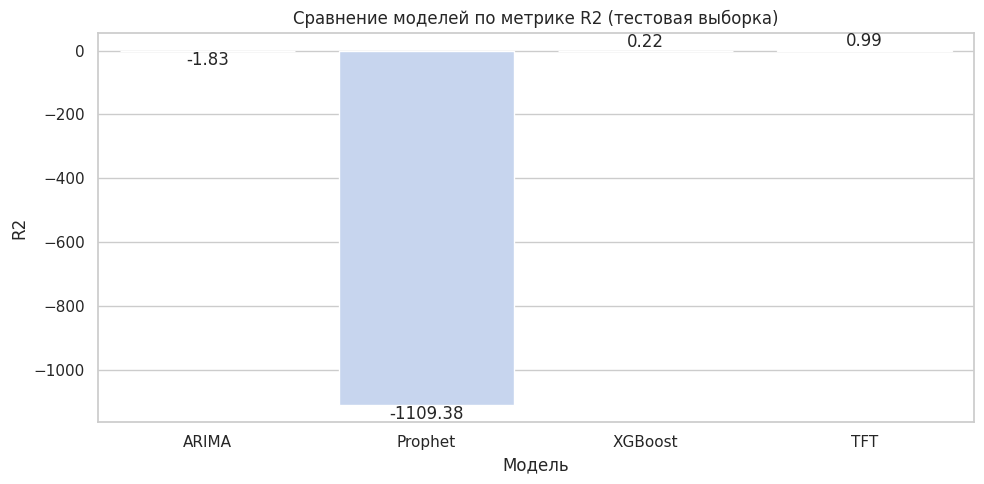

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

metrics_list = ['MAE', 'MSE', 'RMSE', 'MAPE', 'R2']

for metric in metrics_list:
    plt.figure(figsize=(10, 5))

    sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')

    plt.title(f'Сравнение моделей по метрике {metric} (тестовая выборка)')
    plt.ylabel(metric)
    plt.xlabel('Модель')

    # Добавляем аннотации значений с точностью до 2-х знаков после запятой
    for container in plt.gca().containers:
        plt.bar_label(container, fmt='%.2f')

    plt.tight_layout()
    plt.show()

<ipython-input-11-4b8dc8a16639>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')


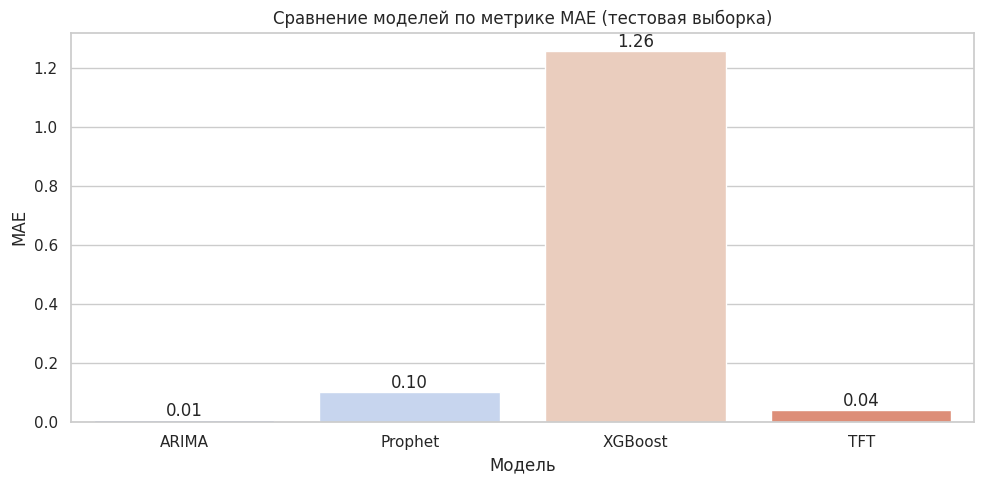

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
metric = 'MAE'

plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')
plt.title(f'Сравнение моделей по метрике {metric} (тестовая выборка)')
plt.ylabel(metric)
plt.xlabel('Модель')

for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

<ipython-input-12-ab46ad682461>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')


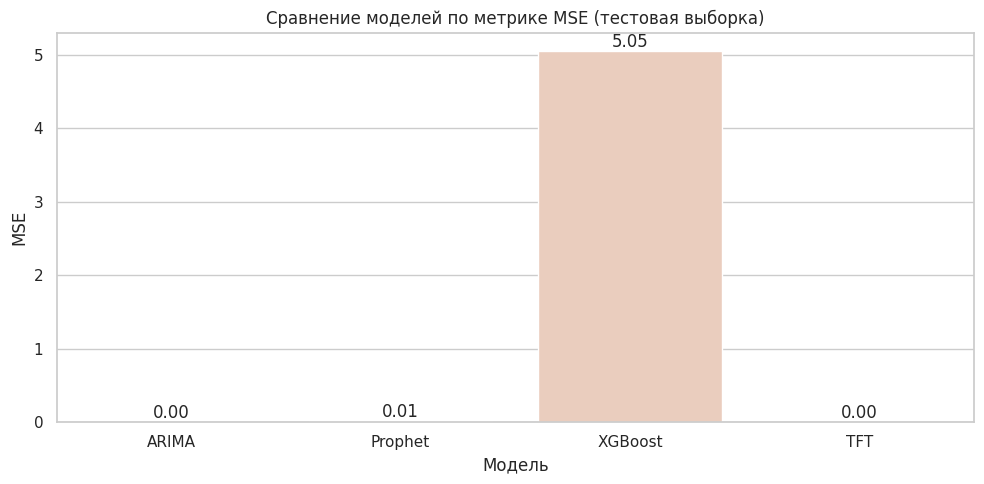

In [12]:
metric = 'MSE'

plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')
plt.title(f'Сравнение моделей по метрике {metric} (тестовая выборка)')
plt.ylabel(metric)
plt.xlabel('Модель')

for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

<ipython-input-13-7a2f08edf85e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')


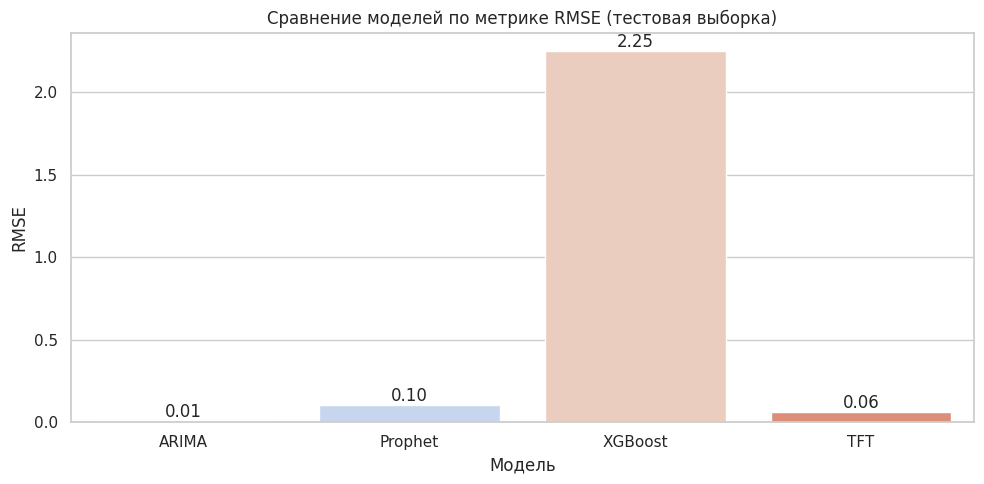

In [13]:
metric = 'RMSE'

plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')
plt.title(f'Сравнение моделей по метрике {metric} (тестовая выборка)')
plt.ylabel(metric)
plt.xlabel('Модель')

for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

<ipython-input-14-a75840e2b31b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')


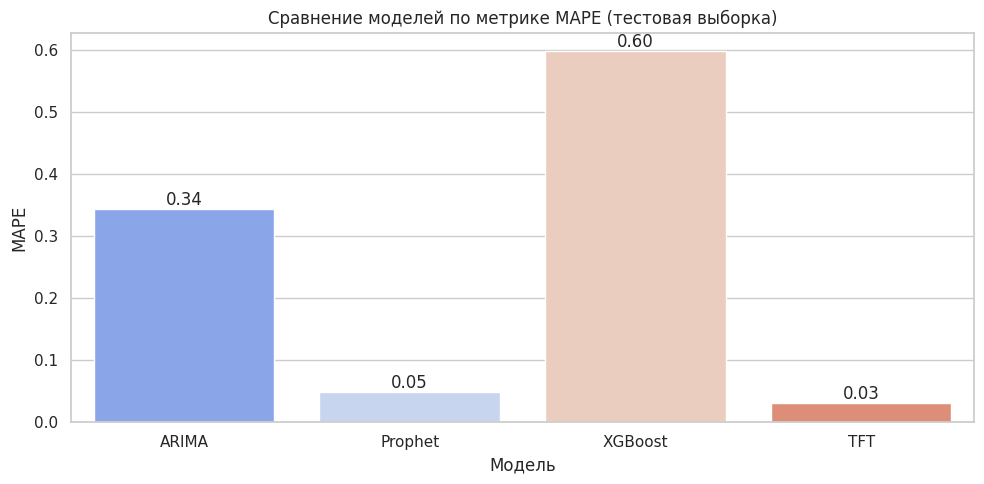

In [14]:
metric = 'MAPE'

plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y=metric, palette='coolwarm')
plt.title(f'Сравнение моделей по метрике {metric} (тестовая выборка)')
plt.ylabel(metric)
plt.xlabel('Модель')

for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

<ipython-input-16-33029e1b0811>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df_plot, x='Model', y=metric, palette='coolwarm')


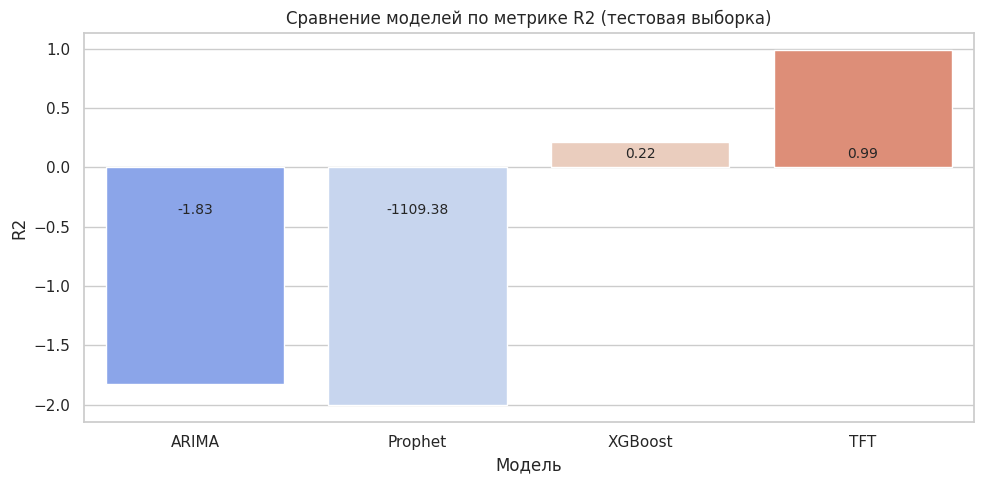

In [16]:
import numpy as np

metric = 'R2'

# Создаём копию DataFrame и ограничиваем значения R2 для визуализации
metrics_df_plot = metrics_df.copy()
metrics_df_plot[metric] = np.clip(metrics_df_plot[metric], -2, 1)

plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df_plot, x='Model', y=metric, palette='coolwarm')
plt.title(f'Сравнение моделей по метрике {metric} (тестовая выборка)')
plt.ylabel(metric)
plt.xlabel('Модель')

# Подписываем реальными значениями R2 сверху над барами
for i, real_value in enumerate(metrics_df[metric]):
    plt.text(i, 0.05 if real_value > 0 else -0.3, f"{real_value:.2f}", ha='center', va='bottom' if real_value > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()

<ipython-input-17-17d546e0560d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics.index, y=metrics.values, palette='Blues_r')


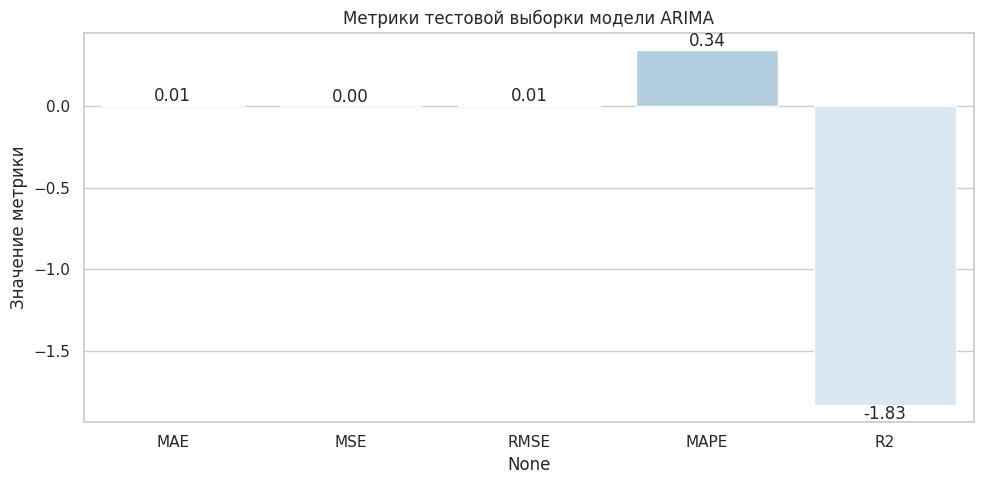

In [17]:
model_name = 'ARIMA'
metrics = metrics_df[metrics_df['Model'] == model_name].iloc[0].drop('Model')

plt.figure(figsize=(10, 5))
sns.barplot(x=metrics.index, y=metrics.values, palette='Blues_r')
plt.title(f'Метрики тестовой выборки модели {model_name}')
plt.ylabel('Значение метрики')

for i, v in enumerate(metrics.values):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom' if v > 0 else 'top')

plt.tight_layout()
plt.show()

<ipython-input-22-ad69b297daaf>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metrics.index, y=metrics.values, palette='Oranges_r')


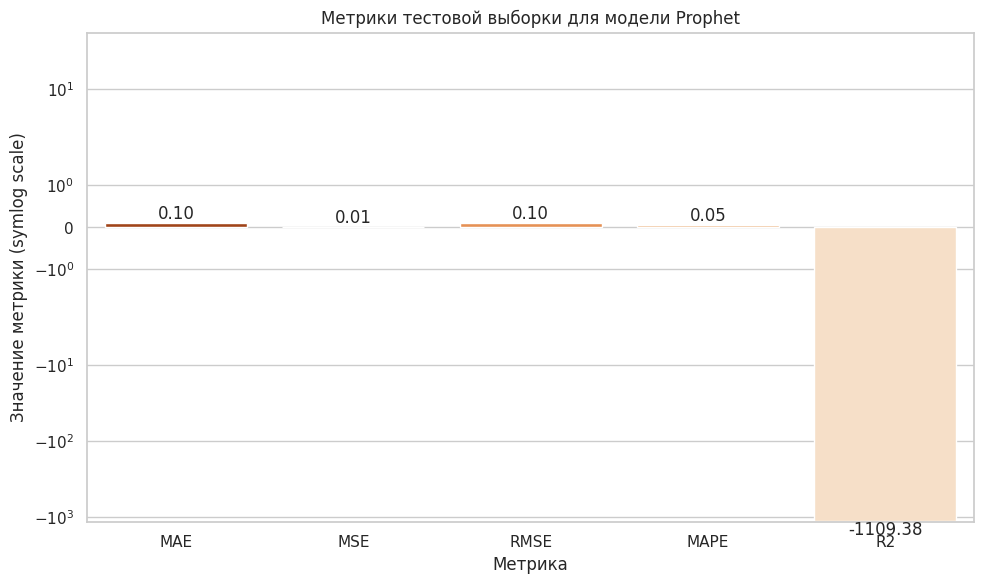

In [22]:
model_name = 'Prophet'
metrics = metrics_df[metrics_df['Model'] == model_name].iloc[0].drop('Model')

# Основные метрики
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=metrics.index, y=metrics.values, palette='Oranges_r')

# Устанавливаем логарифмическую шкалу по оси Y для лучшей читаемости
ax.set_yscale('symlog')

plt.title(f'Метрики тестовой выборки для модели {model_name}')
plt.ylabel('Значение метрики (symlog scale)')
plt.xlabel('Метрика')

# Добавляем подписи
for i, v in enumerate(metrics.values):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom' if v >= 0 else 'top')

plt.tight_layout()
plt.show()

<ipython-input-19-e17bf967cdbe>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics.index, y=metrics.values, palette='Greens_r')


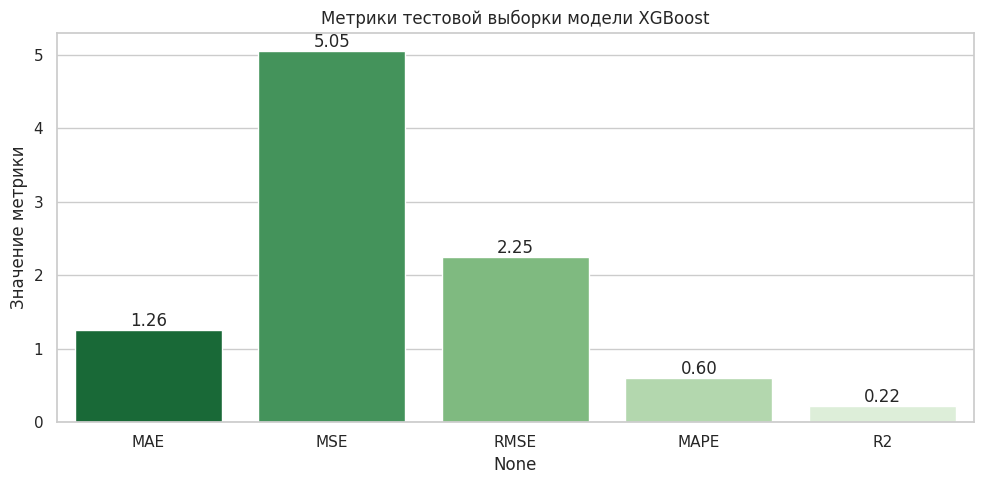

In [19]:
model_name = 'XGBoost'
metrics = metrics_df[metrics_df['Model'] == model_name].iloc[0].drop('Model')

plt.figure(figsize=(10, 5))
sns.barplot(x=metrics.index, y=metrics.values, palette='Greens_r')
plt.title(f'Метрики тестовой выборки модели {model_name}')
plt.ylabel('Значение метрики')

for i, v in enumerate(metrics.values):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom' if v > 0 else 'top')

plt.tight_layout()
plt.show()

<ipython-input-20-184c3036a49e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics.index, y=metrics.values, palette='Reds_r')


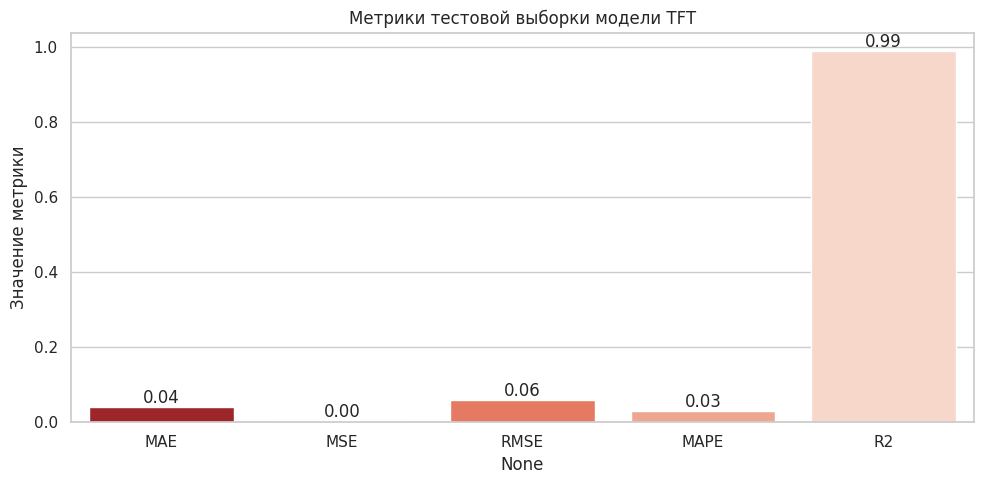

In [20]:
model_name = 'TFT'
metrics = metrics_df[metrics_df['Model'] == model_name].iloc[0].drop('Model')

plt.figure(figsize=(10, 5))
sns.barplot(x=metrics.index, y=metrics.values, palette='Reds_r')
plt.title(f'Метрики тестовой выборки модели {model_name}')
plt.ylabel('Значение метрики')

for i, v in enumerate(metrics.values):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom' if v > 0 else 'top')

plt.tight_layout()
plt.show()